# Предсказание данных **sin(x)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from models.pl_model import NeuralNetworkPL
from datasets.dataset import CustomDataset

### Подготовка данных

In [ ]:
X = np.random.rand(1000, 1) * 10
y = np.sin(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train_dataset = CustomDataset(X_train_scaled, y_train)
val_dataset = CustomDataset(X_val_scaled, y_val)
test_dataset = CustomDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=5, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=5, persistent_workers=True)

### Обучение модели

In [4]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
model = NeuralNetworkPL(
    input_size=1,
    hidden_sizes=[100, 50],
    output_size=1,
    activation='relu',
    task='regression'
)

trainer = pl.Trainer(max_epochs=200, accelerator="auto", log_every_n_steps=10)
trainer.fit(model, train_loader, val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\University\NeuralNetworks\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 5.3 K  | train
--------------------------------------------
5.3 K     Trainab

Epoch 199: 100%|██████████| 20/20 [00:00<00:00, 176.18it/s, v_num=5]       

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 20/20 [00:00<00:00, 168.20it/s, v_num=5]


### Тестирование

In [5]:
trainer.test(model, dataloaders=test_loader)

Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 189.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  0.00019667526066768914   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.00019667526066768914}]

### Визуализация

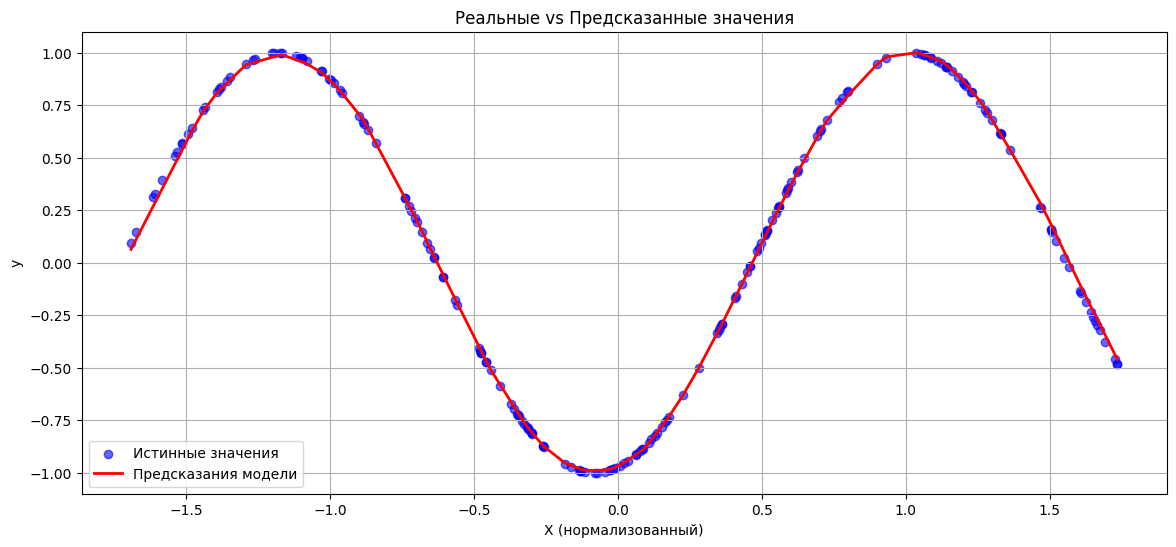

In [9]:
model.eval()
X_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_tensor).numpy()

sorted_indices = np.argsort(X_test_scaled[:, 0])
plt.figure(figsize=(14, 6))
plt.scatter(X_test_scaled[sorted_indices].flatten(), y_test[sorted_indices].flatten(),
            label='Истинные значения', color='blue', alpha=0.6)
plt.plot(X_test_scaled[sorted_indices].flatten(), predictions[sorted_indices].flatten(),
         label='Предсказания модели', color='red', linewidth=2)
plt.title('Реальные vs Предсказанные значения')
plt.xlabel('X (нормализованный)')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()